<a href="https://colab.research.google.com/github/VivekKejriwal/TheSchoolOfAI/blob/main/Assignment_5/Step2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
#!pip install torch
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn.functional as F

In [14]:
#REQUIRED TRANSFORMS CREATED

train_transforms = transforms.Compose([
    
    transforms.ToTensor(),
    transforms.Normalize((.1307,),(0.3081,))
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((.1307,),(0.3081,))
])

In [15]:
#LOADING REQUIRED MNIST DATA

train = datasets.MNIST('./data',download=True,train=True,transform= train_transforms)
test  = datasets.MNIST('./data',download=True,train=False,transform= test_transforms)

In [16]:
SEED = 1

#CUDA?
cuda = torch.cuda.is_available()
#print(cuda)

torch.manual_seed(SEED)

if cuda:
  torch.cuda.manual_seed(SEED)

dataloader_args = dict(shuffle=True, batch_size = 128, num_workers=4,pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

#train loader

train_loader = torch.utils.data.DataLoader(train,**dataloader_args)

#test loader

test_loader = torch.utils.data.DataLoader(test,**dataloader_args)

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
Numpy shape:  torch.Size([28, 60000, 28])
Tensor size:  torch.Size([60000, 28, 28])
min:  tensor(-0.4242)
max:  tensor(2.8215)
mean:  tensor(-0.0001)
variance:  tensor(1.0001)
standard deviation:  tensor(1.0000)
torch.Size([128, 1, 28, 28])
torch.Size([128])


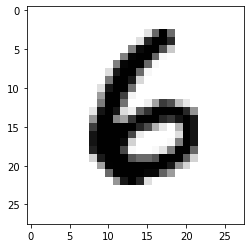

In [17]:
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print("[Train]")
print("Numpy shape: ",train_data.shape)
print("Tensor size: ",train.train_data.shape)
print("min: ",torch.min(train_data))
print("max: ",torch.max(train_data))
print("mean: ",torch.mean(train_data))
print("variance: ",torch.var(train_data))
print("standard deviation: ",torch.std(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


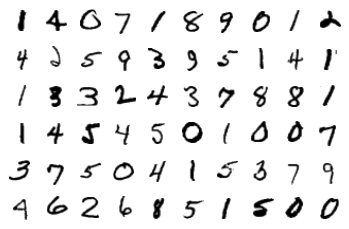

In [18]:
figure = plt.figure()
num_of_images = 60
for index in range(1,num_of_images+1):
  plt.subplot(6,10,index)
  plt.axis('off')
  plt.imshow(images[index].numpy().squeeze(),cmap='gray_r') 

In [19]:
class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()

    self.conv1 = nn.Sequential(
        nn.Conv2d(1,8,3,padding=1), #INPUT- 28X28X1 OUTPUT- 28X28X8 RF- 3
        nn.ReLU(),
        nn.Conv2d(8,8,3,padding=1), #INPUT- 28X28X8 OUTPUT- 28X28X8 RF- 5
        nn.ReLU(),
        nn.MaxPool2d(2,2) #RF- 6
    )

    self.conv2 = nn.Sequential(
        nn.Conv2d(8,16,3,padding=1), #INPUT- 14X14X8 OUTPUT- 14X14X16 RF- 10
        nn.ReLU(),
        nn.Conv2d(16,16,3,padding=1),#INPUT- 14X14X16 OUTPUT- 14X14X16 RF-14
        nn.ReLU(),
        nn.MaxPool2d(2,2) #RF- 16
    )
    self.conv3 = nn.Sequential(
        nn.Conv2d(16,8,3), #INPUT- 7X7X16 OUTPUT- 5X5X8 RF- 24
        nn.ReLU(),
        nn.Conv2d(8,8,3), #INPUT- 5X5X8 OUTPUT- 3X3X8 RF- 32
        nn.ReLU(),
        nn.Conv2d(8,10,3) #INPUT- 3X3X8 OUTPUT- 1X1X10 RF-40
    )

  def forward(self,x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = x.view(-1,10)
    return F.log_softmax(x, dim=1)


In [20]:
!pip install torchsummary

from torchsummary import summary

device = torch.device("cuda" if cuda else "cpu")
print(device)

model = Net().to(device)
summary(model, input_size = (1, 28, 28))


cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
              ReLU-2            [-1, 8, 28, 28]               0
            Conv2d-3            [-1, 8, 28, 28]             584
              ReLU-4            [-1, 8, 28, 28]               0
         MaxPool2d-5            [-1, 8, 14, 14]               0
            Conv2d-6           [-1, 16, 14, 14]           1,168
              ReLU-7           [-1, 16, 14, 14]               0
            Conv2d-8           [-1, 16, 14, 14]           2,320
              ReLU-9           [-1, 16, 14, 14]               0
        MaxPool2d-10             [-1, 16, 7, 7]               0
           Conv2d-11              [-1, 8, 5, 5]           1,160
             ReLU-12              [-1, 8, 5, 5]               0
           Conv2d-13              [-1, 8, 3, 3]             584
             ReLU-14              

In [21]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model,device,train_loader,optimizer,epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  
  for batch_id,(data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    y_pred = model(data)

    loss= F.nll_loss(y_pred,target)
    train_losses.append(loss)

    loss.backward()
    optimizer.step()

    pred = y_pred.argmax(dim=1, keepdim=True)
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed+= len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_size={batch_id} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model,device,test_loader):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      test_loss = F.nll_loss(output, target, reduction='sum').item()
      pred = output.argmax(dim= 1,keepdim=True)
      correct+= pred.eq(target.view_as(pred)).sum().item()

  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)

  print('\nTest set: Average loss: {:.4f}, Acccuracy= {}/{} ({:.2f}%)\n'.format(
      test_loss, correct, len(test_loader.dataset),
      100.*correct/len(test_loader.dataset)))
  
  test_acc.append(100.*correct/len(test_loader.dataset))



In [22]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(),lr=0.01,momentum=0.9)

EPOCHS = 20

for epoch in range(EPOCHS):
  print("EPOCH: ",epoch)
  train(model,device,train_loader,optimizer,epoch)
  test (model,device,test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH:  0


Loss=0.19149307906627655 Batch_size=468 Accuracy=46.88: 100%|██████████| 469/469 [00:11<00:00, 39.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9358/10000 (93.58%)

EPOCH:  1


Loss=0.04163506627082825 Batch_size=468 Accuracy=95.23: 100%|██████████| 469/469 [00:12<00:00, 37.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0001, Acccuracy= 9660/10000 (96.60%)

EPOCH:  2


Loss=0.1144605278968811 Batch_size=468 Accuracy=97.22: 100%|██████████| 469/469 [00:11<00:00, 40.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9743/10000 (97.43%)

EPOCH:  3


Loss=0.1633267104625702 Batch_size=468 Accuracy=97.91: 100%|██████████| 469/469 [00:11<00:00, 39.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9794/10000 (97.94%)

EPOCH:  4


Loss=0.053960416465997696 Batch_size=468 Accuracy=98.19: 100%|██████████| 469/469 [00:11<00:00, 39.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9765/10000 (97.65%)

EPOCH:  5


Loss=0.017051296308636665 Batch_size=468 Accuracy=98.44: 100%|██████████| 469/469 [00:12<00:00, 37.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9824/10000 (98.24%)

EPOCH:  6


Loss=0.039583124220371246 Batch_size=468 Accuracy=98.59: 100%|██████████| 469/469 [00:11<00:00, 39.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9809/10000 (98.09%)

EPOCH:  7


Loss=0.03702341765165329 Batch_size=468 Accuracy=98.67: 100%|██████████| 469/469 [00:12<00:00, 38.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9856/10000 (98.56%)

EPOCH:  8


Loss=0.02276800572872162 Batch_size=468 Accuracy=98.79: 100%|██████████| 469/469 [00:11<00:00, 40.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0001, Acccuracy= 9853/10000 (98.53%)

EPOCH:  9


Loss=0.04917373135685921 Batch_size=468 Accuracy=98.85: 100%|██████████| 469/469 [00:11<00:00, 40.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9868/10000 (98.68%)

EPOCH:  10


Loss=0.002634940668940544 Batch_size=468 Accuracy=98.96: 100%|██████████| 469/469 [00:11<00:00, 39.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9859/10000 (98.59%)

EPOCH:  11


Loss=0.02073836326599121 Batch_size=468 Accuracy=99.02: 100%|██████████| 469/469 [00:12<00:00, 38.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9868/10000 (98.68%)

EPOCH:  12


Loss=0.0017490946920588613 Batch_size=468 Accuracy=99.05: 100%|██████████| 469/469 [00:11<00:00, 39.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9879/10000 (98.79%)

EPOCH:  13


Loss=0.05540626123547554 Batch_size=468 Accuracy=99.05: 100%|██████████| 469/469 [00:12<00:00, 38.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9830/10000 (98.30%)

EPOCH:  14


Loss=0.008348895236849785 Batch_size=468 Accuracy=99.17: 100%|██████████| 469/469 [00:12<00:00, 39.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9870/10000 (98.70%)

EPOCH:  15


Loss=0.002439838135614991 Batch_size=468 Accuracy=99.22: 100%|██████████| 469/469 [00:12<00:00, 39.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9875/10000 (98.75%)

EPOCH:  16


Loss=0.008591157384216785 Batch_size=468 Accuracy=99.21: 100%|██████████| 469/469 [00:11<00:00, 40.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9892/10000 (98.92%)

EPOCH:  17


Loss=0.046477511525154114 Batch_size=468 Accuracy=99.25: 100%|██████████| 469/469 [00:11<00:00, 39.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9888/10000 (98.88%)

EPOCH:  18


Loss=0.10496708005666733 Batch_size=468 Accuracy=99.31: 100%|██████████| 469/469 [00:11<00:00, 40.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9888/10000 (98.88%)

EPOCH:  19


Loss=0.0034657043870538473 Batch_size=468 Accuracy=99.36: 100%|██████████| 469/469 [00:11<00:00, 39.98it/s]



Test set: Average loss: 0.0000, Acccuracy= 9871/10000 (98.71%)



Text(0.5, 1.0, 'Test Accuracy')

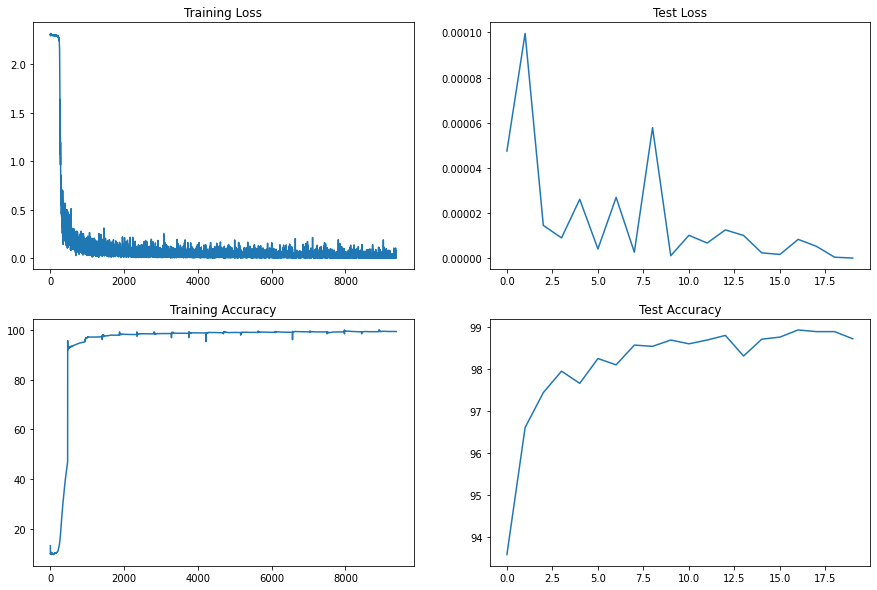

In [23]:
fig, axs = plt.subplots(2,2, figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

Target:

   Target:

     Make the model lighter

  Results:

        Parameters: 6.6k
        Best Train Accuracy: 99.36
        Best Test Accuracy: 98.92
  Analysis:

        Good model!
        A little over-fitting
        Let's focus and see if we can improve the efficiency later

